# Проект: статистический анализ данных

## Введение

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.<br>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:<br>
1. без подписки<br>
абонентская плата отсутствует;<br>
стоимость одной минуты поездки — 8 рублей;<br>
стоимость старта (начала поездки) — 50 рублей;<br>
2. с подпиской Ultra <br>
абонентская плата — 199 рублей в месяц;<br>
стоимость одной минуты поездки — 6 рублей;<br>
стоимость старта — бесплатно.<br>

### Цель исследования:


1. Анализ данных сервиса о пользователях и поездках;
2. Расчет необходимых метрик;
3. Проверка гипотез, которые могут повлиять на дальнешее развитие сервиса.

### Ход исследования:


1. Загрузка данных и первый взгляд на них;
2. Предобработка данных: поиск и исправление ошибок в исходных данных;
3. Исследовательский анализ данных: описание и визуализизация общей информации о пользователях и поездках;
4. Расчет выручки и ее сравнение для пользоваьелей с разной подпиской;
5. Проверка гипотез и выводы;
6. Решение задач по распределению данных.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

## Шаг 1. Загрузка данных

Общий взгляд на данные:

In [ ]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [ ]:
display(data_users.head())
display(data_rides.head())
display(data_subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
print(data_users.info())
print('~'*70)
print(data_rides.info())
print('~'*70)
print(data_subscriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~

ВЫВОДЫ

Файл с исходными данными открыт и изучен. Требуется проведение предобработки данных.

## Шаг 2. Предобработка данных

### Поиск и заполнение пропущенных данных

Пропущенные данные отсутствуют.


### Изменение типа данных

Изменим тип данных в колонке 'date' в DataFrame 'data_rides':


In [ ]:
data_rides['date'] = pd.to_datetime(data_rides['date'])
data_rides['date']

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

Эти данные получены за 1 год? Проверим:

In [ ]:
 data_rides['date'].dt.year.unique()

array([2021])

Создадим столбец с номером месяца на основе столбца 'date'.

In [ ]:
data_rides['date_month'] = data_rides['date'].dt.month
data_rides[['date_month', 'date']].head()

,date_month,date
0,1,2021-01-01
1,1,2021-01-18
2,4,2021-04-20
3,8,2021-08-11
4,8,2021-08-28


### Поиск и удаление дубликатов

Поиск и удаление явных дубликатов:

In [ ]:
print(data_users.duplicated().sum())
print(data_rides.duplicated().sum())
print(data_subscriptions.duplicated().sum())

31
0
0


In [ ]:
data_users[data_users.duplicated()].head()

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free


In [ ]:
data_users = data_users.drop_duplicates().reset_index()
print(data_users.duplicated().sum())

0


Поиск и удаление неявных дубликатов

Проверим неявные дубликаты в столбцах, где они могут быть: 'name' и 'city'.

In [ ]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [ ]:
data_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

Неявных дубликатов не обнаружено.<br><br><br>
Для лучшей читаемости округлим значения столбцов 'distance' и 'duration'. Тип данных в 'distance' переведем в Int32:


In [ ]:
data_rides['distance'] = data_rides['distance'].round(0).astype('int32')

# сначала здесь был round, но, когда дошел до расчета выручки, оставил округление столбца 'duration' на потом.
# data_rides['duration'] = data_rides['duration']round(1).astype('int32')

ВЫВОДЫ <br>
Проведена предобработка данных.
Добавлен новый столбец, который пригодится в дальнейшем исселодовании.

## Шаг 3. Исследовательский анализ данных

Теперь данные готовы к работе.


- Визуализируем информацию о частоте встречающихся городов:

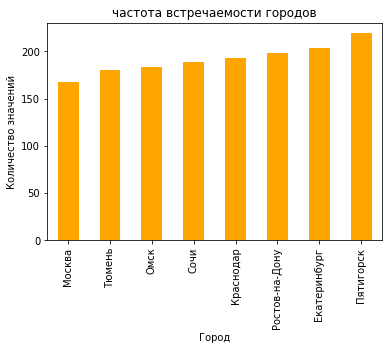

In [ ]:
(data_users['city']
    .value_counts(ascending=True)
    .plot(kind='bar', color='orange')
)
plt.title('частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество значений')
pass

Чаще всего встречается г.Пятигорск. Даже не Москва. И где СПб? <br><br>

- Далее исследуем соотнощение пользователей с подпиской и без нее:

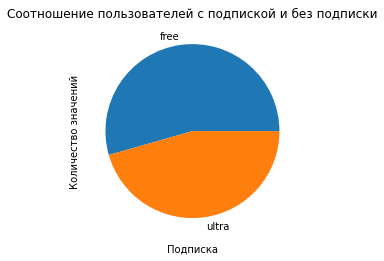

In [ ]:
(data_users['subscription_type']
    .value_counts()
    .plot(kind='pie')
)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Подписка')
plt.ylabel('Количество значений')
pass

In [ ]:
data_users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [ ]:
print('Доля пользователей с подпиской ultra:', \
      (data_users[data_users['subscription_type'] == 'ultra']['subscription_type'].count() / data_users['subscription_type'].count()).round(2))
print('Доля пользователей с подпиской free:', \
      (data_users[data_users['subscription_type'] == 'free']['subscription_type'].count() / data_users['subscription_type'].count()).round(2))

Доля пользователей с подпиской ultra: 0.46
Доля пользователей с подпиской free: 0.54


Пользователей без подписки больше. Реалистично. <br><br>
- Взглянем на пользователей:

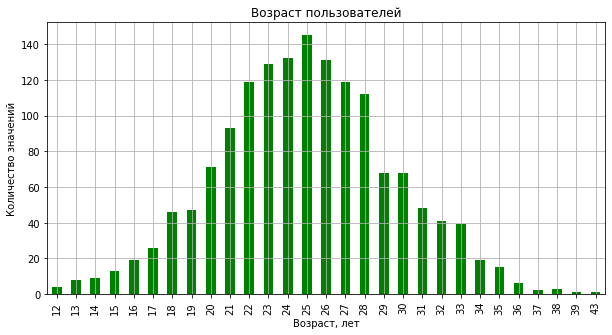

In [ ]:
(data_users['age']
    .value_counts(ascending=True, sort=False)
    .plot(kind='bar', color='g', figsize=(10,5), grid=True)
)
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество значений')
pass

Представленная ниже диаграмма размаха показывает, что возраст пользователей <= 12 лет и >=38 лет считается выбросом.

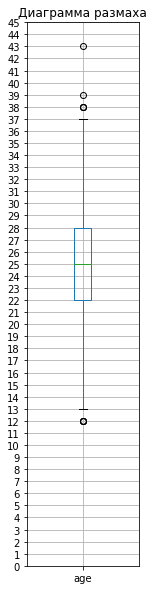

In [ ]:
data_users.boxplot('age', figsize=(2,10))
plt.title('Диаграмма размаха')
plt.yticks(np.arange(0, 46, 1))

pass

22-28 лет - наиболее часто встречающийся диапазон возраста. <br>
25 лет - самый частовстречающийся возраст. <br>
Возраст <18 лет: насколько мне известно, пользователи могут регистрироваться на сервисах кикшеринга с 18 лет. Может быть, в 2021 году не было возрастного ценза при регистрации, но 12-14 лет точно не было бы (в таком возрасте нет паспорта).<br>
Люди в возрасте >43 лет не пользуются сервисом. <br><br><br>
- Проанализируем расстояние, которое пользователь преодолел за одну поездку:

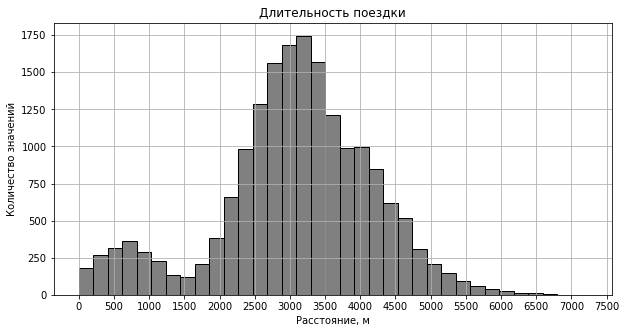

In [ ]:
(data_rides['distance']
    .plot(kind='hist', color='grey', bins=35, figsize=(10,5), grid=True, edgecolor='black')
)
plt.title('Длительность поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество значений')
plt.xticks(np.arange(0, 8000, 500))
pass

In [ ]:
print(data_rides['distance'].describe())

count    18068.000000
mean      3070.659010
std       1116.832209
min          1.000000
25%       2543.000000
50%       3134.000000
75%       3776.000000
max       7211.000000
Name: distance, dtype: float64


Согласно диаграмме размаха расстояния <750 м, также как и расстояния >5625 м считаются выбросами.

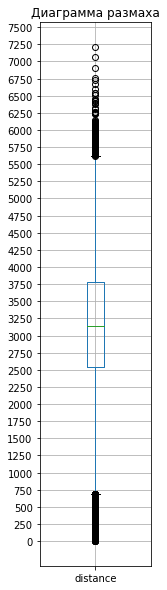

In [ ]:
data_rides.boxplot('distance', figsize=(2,10))
plt.title('Диаграмма размаха')
plt.yticks(np.arange(0, 7700, 250))

pass

Наиболее часто проезжают расстояние ~(2,5-3,8) км. Есть второй маленький пик в районе 0,75 км. <br><br><br>
- Также рассмотрим продолжительность поездки:

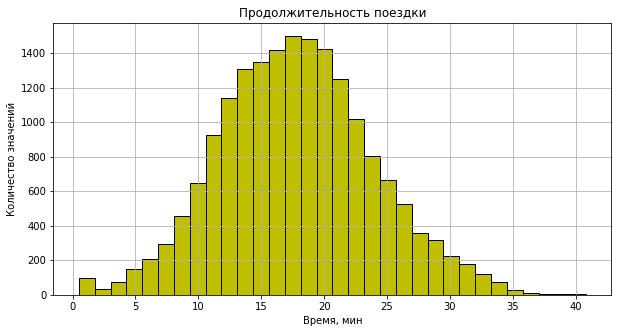

In [ ]:
(data_rides['duration']
    .plot(kind='hist', color='y', bins=32, figsize=(10,5), grid=True, edgecolor='black')
)
plt.title('Продолжительность поездки')
plt.xlabel('Время, мин')
plt.ylabel('Количество значений')

pass

In [ ]:
print(data_rides['duration'].describe())

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


Диаграмма размаха показывает, что значения <1 мин, а также =>34 мин  - выбросы:

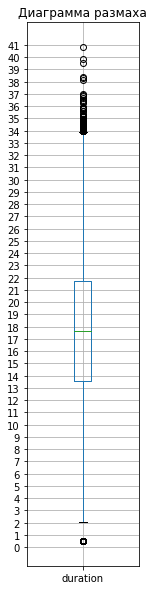

In [ ]:
data_rides.boxplot('duration', figsize=(2,10))
plt.title('Диаграмма размаха')
plt.yticks(np.arange(0, 42, 1))

pass

Чаще всего поездку совершали в течение ~17,5 минут. При этом медиана и ср. арифметическое практически равны.

ВЫВОДЫ<br>
Описана общая информация о пользователях и поездках:<br><br>

Чаще всего сервисом пользуются в г.Пятигорск. <br>
Пользователей без подписки больше, чем пользователей с подпиской (на 19,5%).<br>
22-28 лет - наиболее часто встречающийся диапазон возраста. <br>
25 лет - самый частовстречающийся возраст. <br>
Наиболее часто проезжают расстояние ~(2,5-3,8) км. Есть второй маленький пик в районе 0,75 км. <br>
Чаще всего поездку совершали в течение ~17,5 минут.



## Шаг 4. Объединение данных

- Объединим данные о пользователях, поездках и подписках в один DataFrame:

In [ ]:
data_united = data_users.merge(data_rides, on='user_id') \
    .merge(data_subscriptions, on='subscription_type')

data_united.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4410,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2618,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2695,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4029,26.265803,2021-08-28,8,6,0,199


In [ ]:
data_united.isna().sum()

index                0
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
date_month           0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Размеры исходных и результирующего DataFrame:

In [ ]:
print('Размер DataFrame data_users:', data_users.shape)
print('Размер DataFrame data_rides:', data_rides.shape)
print('Размер DataFrame data_subscriptions:', data_subscriptions.shape)
print('Размер объединенного DataFrame data_united:', data_united.shape)

Размер DataFrame data_users: (1534, 6)
Размер DataFrame data_rides: (18068, 5)
Размер DataFrame data_subscriptions: (2, 4)
Размер объединенного DataFrame data_united: (18068, 13)


Размеры объединенного DataFrame верны.

---
- Создадим два датафрейма из data_united:<br>
c данными о пользователях без подписки;<br>
с данными о пользователях с подпиской.

In [ ]:
data_subscriptions_free = data_united[data_united['subscription_type'] == 'free']
data_subscriptions_ultra = data_united[data_united['subscription_type'] == 'ultra']

In [ ]:
display('Часть объединенной таблицы:', data_united.head())
display('Часть таблицы с данными о пользователях с подпиской free:', data_subscriptions_free.head())
display('Часть таблицы с данными о пользователях с подпиской ultra:', data_subscriptions_ultra.head())

'Часть объединенной таблицы:'

,index,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4410,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2618,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2695,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4029,26.265803,2021-08-28,8,6,0,199


'Часть таблицы с данными о пользователях с подпиской free:'

,index,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
6500,699,700,Айдар,22,Омск,free,2516,14.944286,2021-01-02,1,8,50,0
6501,699,700,Айдар,22,Омск,free,847,16.234663,2021-02-01,2,8,50,0
6502,699,700,Айдар,22,Омск,free,4004,20.016628,2021-02-04,2,8,50,0
6503,699,700,Айдар,22,Омск,free,1206,9.782872,2021-02-10,2,8,50,0
6504,699,700,Айдар,22,Омск,free,3047,17.427673,2021-02-14,2,8,50,0


'Часть таблицы с данными о пользователях с подпиской ultra:'

,index,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4410,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2618,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2695,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4029,26.265803,2021-08-28,8,6,0,199


---
- Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий:

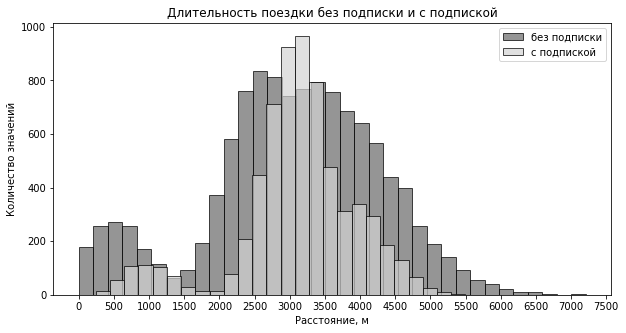

In [ ]:
(data_subscriptions_free['distance']
    .plot(kind='hist', color='dimgrey', bins=35, figsize=(10,5), edgecolor='black', label='без подписки', alpha=0.7)
)
(data_subscriptions_ultra['distance']
    .plot(kind='hist', color='lightgrey', bins=27, edgecolor='black', label='с подпиской', alpha=0.7)
)
plt.title('Длительность поездки без подписки и с подпиской')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество значений')
plt.legend()
plt.xticks(np.arange(0, 8000, 500))
pass

In [ ]:
print(data_subscriptions_ultra['distance'].describe())
print('-'*50)
print(data_subscriptions_free['distance'].describe())

count    6500.000000
mean     3115.443385
std       836.898137
min       244.000000
25%      2785.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64
--------------------------------------------------
count    11568.00000
mean      3045.49490
std       1246.17418
min          1.00000
25%       2367.00000
50%       3115.00000
75%       3906.00000
max       7211.00000
Name: distance, dtype: float64


Распределение длины поездки пользователей без подписки 'шире: их больше, они совершают больше поездок. При этом, пик распределения у них 'обрублен'.
Также пользователи без подписки совершают больше коротких поездок.

Длительность поездки у пользователей с подпиской ultra немного больше, чем длительность поездки у пользователей без подписки.

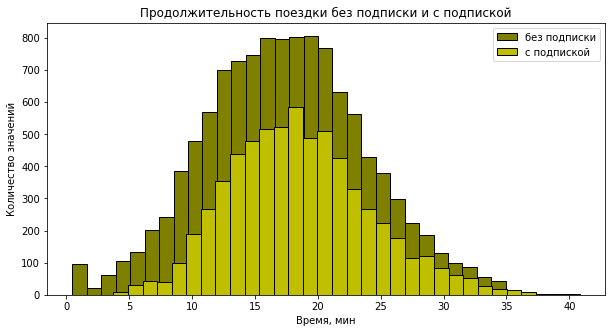

In [ ]:
(data_subscriptions_free['duration']
    .plot(kind='hist', color='olive', bins=30, figsize=(10,5), edgecolor='black', label='без подписки')
)
(data_subscriptions_ultra['duration']
    .plot(kind='hist', color='y', bins=32, edgecolor='black', label='с подпиской')
)
plt.title('Продолжительность поездки без подписки и с подпиской')
plt.xlabel('Время, мин')
plt.ylabel('Количество значений')
plt.legend()

pass

In [ ]:
print(data_subscriptions_ultra['duration'].describe())
print('-'*50)
print(data_subscriptions_free['duration'].describe())

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64
--------------------------------------------------
count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


По времени распределения поездок графики похожи друг на друга. <br>
Но, судя по результатам describe(), среднее время поездки у пользователей с подпиской все-таки больше.

У пользователей без подписки есть маленький пик в районе микропоездок. Можно посмотреть поближе:

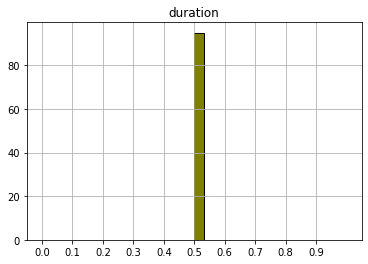

In [ ]:
(data_subscriptions_free
    .query('duration < 2')
    .hist('duration', color='olive', bins=30, edgecolor='black')
)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

Т.к. в бесплатной подписке 'посадка' стоит денег, то, возможно, учитывались случаи, когда пользователь стартовал, но никуда не ехал и завершал поездку (стоимость старта в ultra - бесплатна).

ВЫВОДЫ <br>
На данном этапе создали общий DataFrame из трех имеющихся.<br>
Рассмотрели длительность и продолжительность поездки для пользователей с подпиской и без нее.

## Шаг 5. Подсчёт выручки

Округлим значение продолжительности поездки до целого числа вверх:

In [ ]:
data_united['duration'] = np.ceil(data_united['duration'])

- Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из data_united:<br> найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [ ]:
data_aggregated = data_united.pivot_table(
    index=['user_id', 'date_month'],
    values=['distance', 'duration'],
    aggfunc=({'duration':'sum', 'distance':{'count', 'sum'}})
)
data_aggregated.columns = (['drives', ('total_distance'), ('total_duration')])
data_aggregated.head(15)

drives  total_distance  total_duration
user_id date_month                                        
1       1                2            7028            42.0
        4                1             754             7.0
        8                2            6724            46.0
        10               2            5810            32.0
        11               3            7004            56.0
        12               2            6752            28.0
2       3                3           10188            63.0
        4                2            6165            40.0
        6                1            3255            14.0
        7                2            6781            48.0
        8                1             923             7.0
        10               1            2825            19.0
        12               1            3828            12.0
3       1                1            3062            13.0
        2                2            5421            39.0


- В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. <br>
Обновим сводную таблицу:

In [ ]:
data_aggregated = data_united.pivot_table(
    index=['user_id', 'date_month'],
    values=['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'],
    aggfunc=({'duration':'sum',
              'distance':{'count', 'sum'},
              'minute_price':'mean',
              'start_ride_price':'mean',
              'subscription_fee': 'mean'
             })
)

#data_aggregated.columns
data_aggregated.columns = [('drives'),
            ('total_distance'),
            ('total_duration'),
            ('minute_price'),
            ('start_ride_price'),
            ('subscription_fee')]

data_aggregated.sample(5)

,,drives,total_distance,total_duration,minute_price,start_ride_price,subscription_fee
user_id,date_month,,,,,,
882,12,1,1960,16.0,8,50,0
1023,12,3,7562,46.0,8,50,0
341,1,1,3431,30.0,6,0,199
554,2,1,4075,15.0,6,0,199
690,1,1,2388,19.0,6,0,199


Проверка сводной таблицы на наличие пропусков:

In [ ]:
data_aggregated.isna().sum()

drives              0
total_distance      0
total_duration      0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

Посчитаем выручку за месяц на каждого пользователя (с учетом округлений, сделанных ранее):

In [ ]:
data_aggregated['revenue_per_month'] = (data_aggregated['total_duration'] * data_aggregated['minute_price'] \
+ data_aggregated['start_ride_price'] * data_aggregated['drives'] \
+ data_aggregated['subscription_fee']).astype('int32')

data_aggregated.head()

drives  total_distance  total_duration  minute_price  \
user_id date_month                                                         
1       1                2            7028            42.0             6   
        4                1             754             7.0             6   
        8                2            6724            46.0             6   
        10               2            5810            32.0             6   
        11               3            7004            56.0             6   

                    start_ride_price  subscription_fee  revenue_per_month  
user_id date_month                                                         
1       1                          0               199                451  
        4                          0               199                241  
        8                          0               199                475  
        10                         0               199                391  
        11                         0               199                535

Посмотрим, сколько принесли пользователи с подпиской и без нее:

In [ ]:
data_aggregated.pivot_table(index='subscription_fee', values='revenue_per_month', aggfunc='sum')

,revenue_per_month
subscription_fee,
0,2234104
199,1644537


ВЫВОДЫ <br>
На данном этапе посчитали выручку (помесячно), которую принес каждый пользователь сервиса кикшеринга.<br>
Было отмечено, что пользователи без подписки принесли сервису на 35% больше выручки, чем пользователи с подпиской.

## Шаг 6. Проверка гипотез

- ГИПОТЕЗА 1

Проверяем гипотезу (H0): пользователи с подпиской тратят столько же времени, сколько и пользователи без подписки.<br>
Альтернативная гипотеза (H1): пользователи с подпиской тратят больше времени на поездки.<br>

In [ ]:
alpha = .05

results = st.ttest_ind(data_subscriptions_ultra['duration'], data_subscriptions_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Таким образом, отвергаем гипотезу H0 в пользу альтернативной H1.

---
- ГИПОТЕЗА 2

Проверим гипотезу (H0): среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м.<br>
Альтернативная гипотеза (H1): среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м.<br>

In [ ]:
time_at_site = pd.read_csv('/datasets/user_time.csv')

interested_value = 3130
alpha = .05

results = st.ttest_1samp(data_subscriptions_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')



p-значение: 0.9195649894697724
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута. Таким образом, есть вероятность, что среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 м. Если взглянуть на гистограмму 'Длительность поездки без подписки и с подпиской', то данное значение выглядит правдоподобным. Немного приблизим гистограмму и посмотрим на вершину распределения, чтобы удостовериться в этом еще больше:

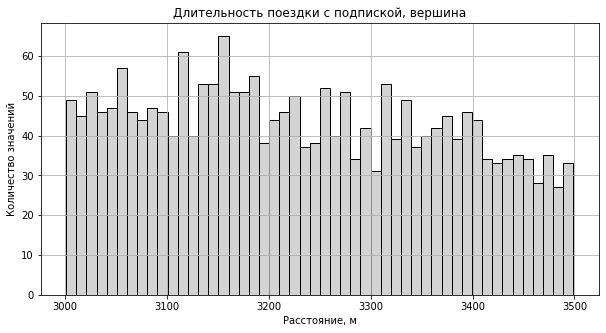

In [ ]:
(data_subscriptions_ultra
    .query('3000 < distance < 3500')
    .hist('distance', color='lightgrey', bins=50, figsize=(10,5), edgecolor='black')
)
plt.title('Длительность поездки с подпиской, вершина')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество значений')
pass

---

- ГИПОТЕЗА 3

Проверим гипотезу (H0): помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.<br>

Альтернативная гипотеза (H1): помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.<br>

In [ ]:
d1 = data_aggregated.query('subscription_fee != 0')['revenue_per_month']
d2 = data_aggregated.query('subscription_fee == 0')['revenue_per_month']
# print(d1)

alpha = .05

results = st.ttest_ind(d1, d2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута в пользу альтернативной при уровне статистической значимости 0.05. <br>:
При этом, общая выручка от пользователей (за весь год) с подпиской меньше, чем общая выручка от пользователей без подписки😕:

In [ ]:
print('Общая выручка (с подпиской):', data_aggregated.query('subscription_fee != 0')['revenue_per_month'].sum(), 'руб.')
print('Общая выручка (без подписки):', data_aggregated.query('subscription_fee == 0')['revenue_per_month'].sum(), 'руб.')


Общая выручка (с подпиской): 1644537 руб.
Общая выручка (без подписки): 2234104 руб.


Посмотрим на среднюю помесячную выручку для каждого типа подписки:

In [ ]:
print(data_aggregated.query('subscription_fee != 0')['revenue_per_month'].describe())
print('-'*50)
print(data_aggregated.query('subscription_fee == 0')['revenue_per_month'].describe())

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue_per_month, dtype: float64
--------------------------------------------------
count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue_per_month, dtype: float64


Средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.<br>
Т.о. результат проверки гипотезы выглядит правдоподобным.


---
- ГИПОТЕЗА 4

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для данного случая применяется гипотеза о равенстве средних для зависимых (парных) выборок.
В таком случае нулевая гипотеза звучит так: среднее количество обращений в тех.поддержку не изменилось после обновлений серверов; <br>
альтернативная: среднее количество обращений в тех.поддержку до обновления серверов больше, чем до этих обновлений.

Чтобы проверить нулевую гипотезу в Python применяют метод **scipy.stats.ttest_rel(data_before, data_after, alternative='greater')**.
При этом, переменная (количество обращений до и после) измеряется дважды, оба набора должны быть одинаковыми по размеру.
---


ВЫВОДЫ<br>

- гипотеза 1:
результат теста показал, что с большой долей вероятности пользователи с подпиской тратят больше времени на поездки, чем пользователи без оной;
- гипотеза 2:
есть основания утверждать, что среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 м;
- гипотеза 3:
очень вероятно, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;
- гипотеза 4:
для данной гипотезы при условии, что выборки зависимы, применяется метод scipy.stats.ttest_rel().

## Шаг 7. Распределения

- Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают
10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Подберем параметры для биномиального распределения для этой ситуации. Мат ожидание мю=n * p. Т.е., чтобы получить 100 клиентов при том, что 10% продлевают подписку, нужно 1000 испытаний (промокодов):

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


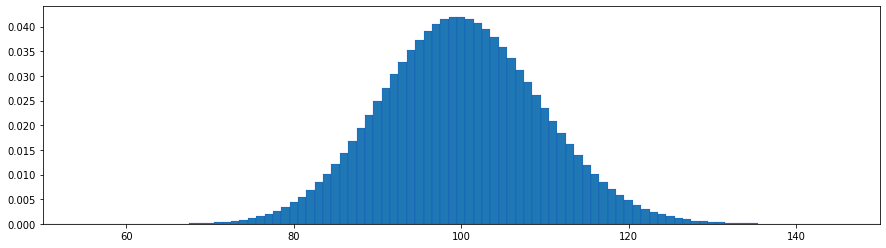

In [ ]:
n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.figure(figsize=(15,4))
plt.bar(range(0, n + 1), distr, edgecolor='b', linewidth=0.1, width=1)
#plt.xticks(np.arange(0, 1000, 50))
plt.xlim([50, 150]) # для читаемости графика зададим границы для значений оси X

pass

При 1000 попытках получаем наиболее вероятное количество положительных исходов = 100.

Теперь нужно найти число промокодов при известной вероятности пригодился бы метод ppf, но его нет для биномиального распределения (или я не верно трактую задачу...).<br>
С помощью метода cdf() можно найти вероятность, при которой произойдет не более k успехов (промокодов). Для 'более k успехов' применяется конструкция 1-cdf(). Вероятность у нас есть, можно подбором подобрать нужное значение k. <br>
Изначально передадим методу cdf() базовые параметры 1-cdf(99, 1000, 0.1). Т.о., методом перебора получаем искомое значение 1161 (такое количество промокодов даст нам вероятность получения 99+ клиентов, равную  95.02 %).

In [ ]:
print(f'Вероятность, что 100 и более клиентов продлят подписку, равна {1-binom.cdf(99, 1161, 0.1):.2%}')

Вероятность, что 100 и более клиентов продлят подписку, равна 95.02%


---
- Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Воспользуемся нормальной аппроксимацией биномиального распределения. Построим график (закомментил, т.к. вычисления проводятся долго):

In [ ]:
'''
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))

#размер графика
plt.figure(figsize=(20,8))

# график биномиального распределения
ax = plt.subplot()

# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
    label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# настройка отображения
ax.plot(x, norm.pdf(x, mu, sigma), 'g-', lw=15, alpha=0.4, label='плотность вероятности нормального распределения')

# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

plt.axvline (x=399500, color='red', linestyle='--', label='399.5k пользователей')

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')
'''
pass

In [ ]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# границы интервала
users = 399500

# считаем вероятность получить значение меньше users
result = distr.cdf(users)
print(f'Вероятность того, что уведомление откроют не более {users / 1000}тыс. пользователей равна {result:.2%}')

Вероятность того, что уведомление откроют не более 399.5тыс. пользователей равна 15.37%


ВЫВОДЫ<br>
Были решены 2 дополнительные задачи по распределениям данных.

<br>

## Общие выводы

В данной работе было необходимо проанализировать данные популярного сервиса кикшеринга GoFast о некоторых пользователях из нескольких городов, а также об их поездках, а также проверить некоторые гипотезы.<br><br>

Была проведена предобработка данных, в том числе:
- проверка на наличие пропущенных значений (они отсутствуют);
- проверка на наличие дубликатов (явных и неявных) и их устранение;
- изменение типов данных некоторых признаков.
Добавлен новый столбец, который пригодится в дальнейшем исселодовании.<br><br>

На этапе исследовательского анализа данных описана общая информация о пользователях и поездках:<br>
- чаще всего сервисом пользуются в г. Пятигорск. <br>
- пользователей без подписки больше, чем пользователей с подпиской (на 19,5%).<br>
- 22-28 лет - наиболее часто встречающийся диапазон возраста. <br>
- 25 лет - самый частовстречающийся возраст. <br>
- наиболее часто проезжают расстояние ~(2,5-3,8) км. Есть второй маленький пик в районе 0,75 км. <br>
- чаще всего поездку совершали в течение ~17,5 минут.<br><br>

Далее был создан общий DataFrame из трех имеющихся, рассмотрена длительность и продолжительность поездки для пользователей с подпиской и без нее: <br>
- длительность поездки у пользователей с подпиской ultra немного больше, чем длительность поездки у пользователей без подписки;
- среднее время поездки у пользователей с подпиской несколько больше, чем среднее время поездки у людей без подписки.<br><br>

Была посчитана выручка (помесячно), которую принес каждый пользователь сервиса кикшеринга. Отмечено, что пользователи без подписки принесли сервису на 35% больше выручки, чем пользователи с подпиской.<br><br>

В заключительном разделе настоящего проекта были проверены предложенные гипотезы. Результаты:
- гипотеза 1:
результат теста показал, что с большой долей вероятности пользователи с подпиской тратят больше времени на поездки, чем пользователи без оной;
- гипотеза 2:
есть основания утверждать, что среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 м;
- гипотеза 3:
очень вероятно, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;
- гипотеза 4:
для данной гипотезы при условии, что выборки зависимы, применяется метод scipy.stats.ttest_rel().<br><br>


Дополнительно решены 2 необязательные задачи по распределениям данных.<br><br>

**В завершение исследования выделю рекомендации по развитию сервиса аренды самокатов GoFast.** <br>
Несмотря на то, что количество пользователей без подписки больше, чем пользователей с подпиской (на 19.5%), средняя помесячная выручка от пользователей с подпиской все же выше. Имеет смысл стимулировать пользователей покупать платную подписку после изучения потенциальной экономической эффективности мер, которые этому поспособствуют. <br>
Например, добавить промокоды на подписку, предлагать скидки на другие сервисы (при их наличии), активнее вести коллаборацию с другими заинтересованными компаниями в части предоставления пользователям более интересных и выгодных предложений.<br>
Можно 'давить' на  возрастную группу 22-28 лет - наиболее часто встречающуюся в наборе данных. <br><br>
Понятно, что в наиболее крупных городах (Москва и СПб) конкуренция между сервисами кикшеринга выше, но, возможно, стоит попытаться увеличить присутствие GoFast на этих территориях.
